## Import Libraries Packages, Downloads

In [1]:
#manipulation and plotting libraries
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math as mt

warnings.filterwarnings('ignore')

In [2]:
#ML libraries
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## Loading and Processing Data
`Note: (Because none of the processing we are doing involves imputation or such, we are doing the processing before the split)`

In [3]:
warnings.filterwarnings('ignore')


Data = pd.read_csv("/kaggle/input/670-final-data/formatted_data.csv")

## Plotting

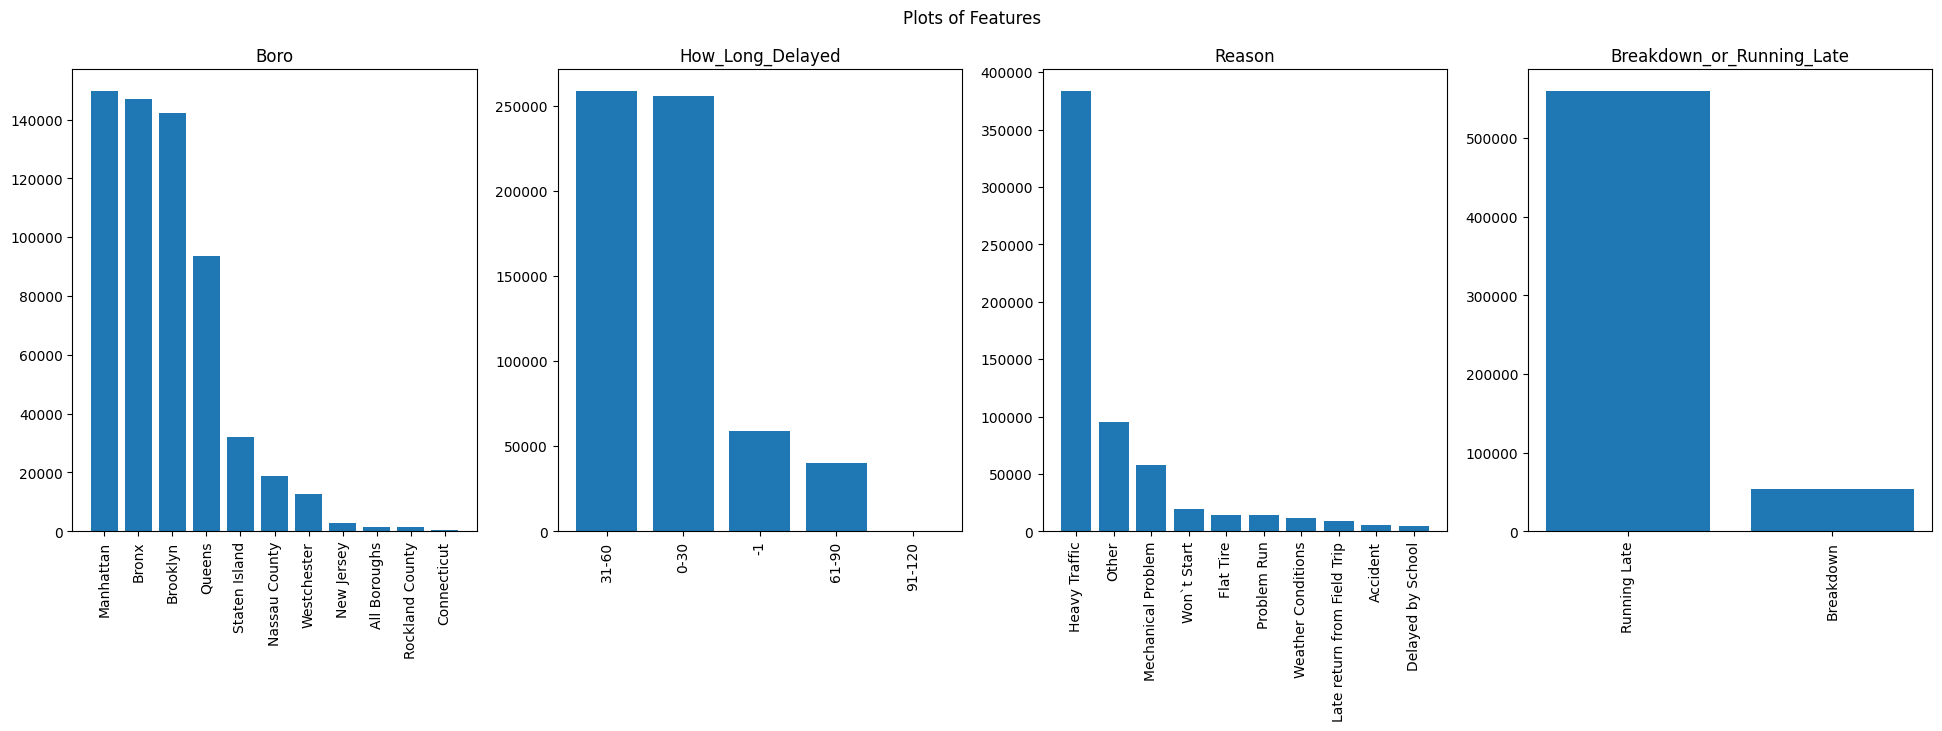

In [4]:
warnings.filterwarnings('ignore')

columns_to_plot_Data = ['Boro','How_Long_Delayed' ,'Reason', 'Breakdown_or_Running_Late']

fig, axs = plt.subplots(1,4, figsize=(24, 6))
fig.suptitle("Plots of Features")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()

i = 0
for column_name in columns_to_plot_Data:

    counts = Data[column_name].value_counts()
    
    # Rotate the tick labels in the second subplot
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f"{column_name}")
    axs[i].set_xticklabels(counts.index, rotation=90)
    i += 1



In [5]:
def process(df): 

    #copy dataframe
    data = df.copy()
    #data.columns = data.columns.astype(str)

    #making a dictionary since we need to do a lot of conversion
    to_binary = {'Yes':1, 'No':0}

    #dropping columns we won't be able to use
    data = data.drop(['Busbreakdown_ID', 'Created_On', 
            'Informed_On','Incident_Number', 
            'Last_Updated_On', 'School_Age_or_PreK', 
            'School_Year', 'Route_Number', 'Schools_Serviced',
            'Run_Type', 'Bus_No', 'Bus_Company_Name'], axis = 1)
    
    data = data.dropna()

    #mapping literals to binary values
    data['Breakdown_or_Running_Late'] = data['Breakdown_or_Running_Late'].map({'Breakdown':1, 'Running Late':0})
    data['Has_Contractor_Notified_Parents'] = data['Has_Contractor_Notified_Parents'].map(to_binary)
    data['Has_Contractor_Notified_Schools'] = data['Has_Contractor_Notified_Schools'].map(to_binary)
    data['Have_You_Alerted_OPT'] = data['Have_You_Alerted_OPT'].map(to_binary)

    #getting month/date values
    data['Occurred_On'] = pd.to_datetime(data['Occurred_On'])
    data['Year'] = data['Occurred_On'].dt.year
    data['Month'] = data['Occurred_On'].dt.month
    data['Day'] = data['Occurred_On'].dt.day
    data['Hour'] = data['Occurred_On'].dt.hour
    data['Mins'] = data['Occurred_On'].dt.minute
    data['Weekday'] = data['Occurred_On'].dt.weekday


    data["sin_month"] = np.sin(2*np.pi*data["Month"]/max(data["Month"]))
    data["cos_month"] = np.cos(2*np.pi*data["Month"]/max(data["Month"]))
    data["sin_hour"] = np.sin(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["cos_hour"] = np.cos(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["sin_mins"] = np.sin(2*np.pi*data["Mins"]/max(data["Mins"]))
    data["cos_mins"] = np.cos(2*np.pi*data["Mins"]/max(data["Mins"]))

    #one hot encode boro
    #data['Boro'] = data['Boro'].fillna('None')
    for boro in data['Boro'].unique():
        data[boro] = (data['Boro'] == boro).astype(int)

    # one hot encode breakdown reason
    for reason in data['Reason'].unique():
        data[reason] = (data['Reason'] == reason).astype(int)

    data = data.drop(['Boro'], axis = 1)
    data = data.drop(['Reason'], axis = 1)

    #plot some features

    i = 0
    columns_to_plot_df = ['Month', 'Day', 'Hour', 'Weekday']

    fig, axs = plt.subplots(1,4, figsize=(24, 6))
    fig.suptitle("Plots of Features")
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()

    for column_name in columns_to_plot_df:
        
        counts = data[column_name].value_counts().sort_index()
        
        # Rotate the tick labels in the second subplot
        axs[i].bar(counts.index, counts.values)
        axs[i].set_title(f"{column_name}")
        i += 1

    data = data.drop(['Occurred_On', 'Month', 'Day', 'Hour', 'Mins'], axis = 1)

    return data


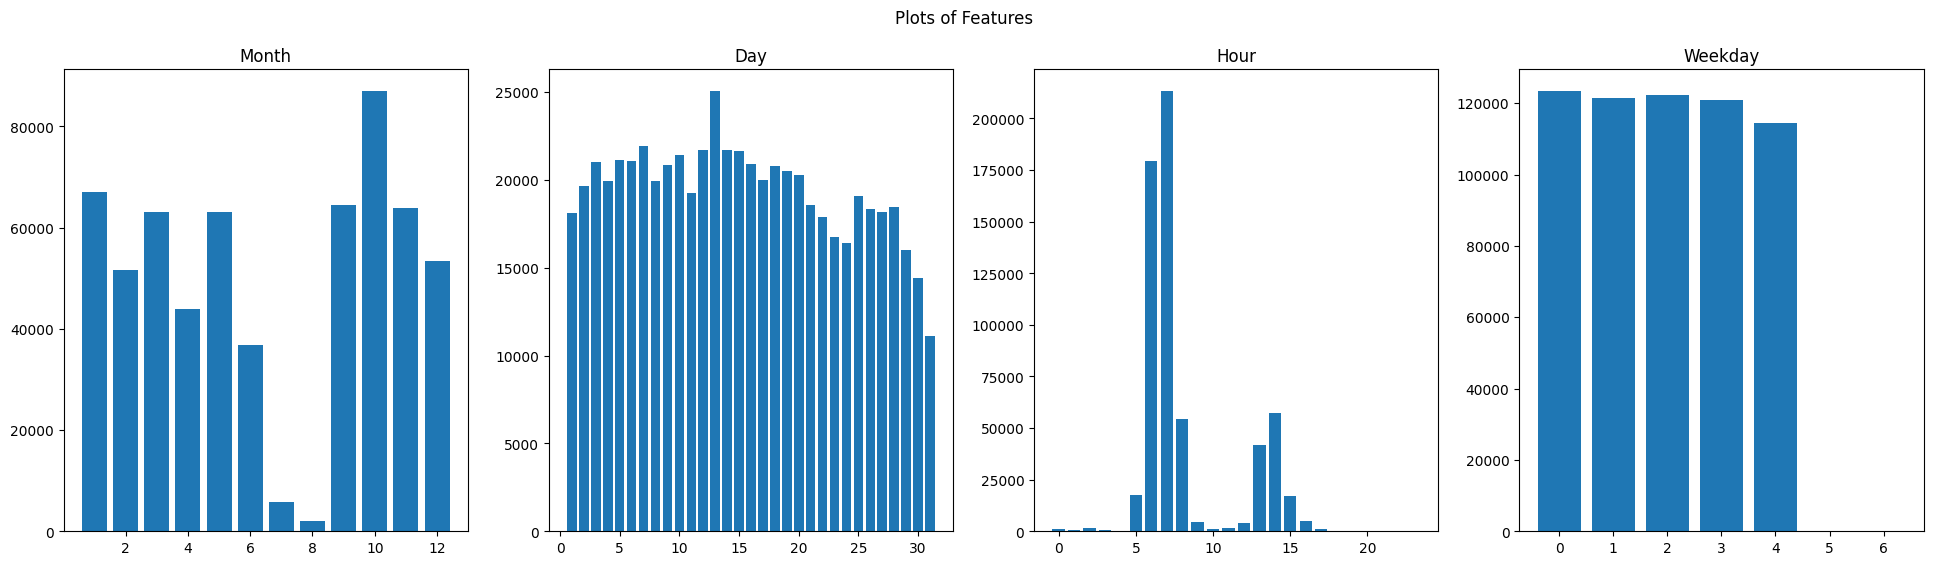

In [6]:
#Process the data
df = process(Data)


### Train Test Split

In [7]:

X = df.drop(['How_Long_Delayed'], axis = 1)
y = df['How_Long_Delayed']

X_train, X_test,y_train, y_test = train_test_split(X,y, test_size= .1)

## Building a Baseline Classifier
#### 1) (Almost) Random Guessing


In [8]:
classes = {0:'0-30', 1: '31-60', 2:'61-90', 3:'91-120', 4:'-1'}

guess = []

for index, row in X_test.iterrows():

    int = 0

    if row.Breakdown_or_Running_Late == 1:
        int = 4
    else:
        int = 1

    guess.append(classes[int])
    
accuracy_score(y_test, guess)



0.512826899128269

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

XGB Classifier

In [22]:
from xgboost import XGBClassifier

# pipe = Pipeline(steps=[
#     ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=1)),
#     ('mod', XGBClassifier())
# ])

# param_grid = {
#     'mod__n_estimators': [500],  
#     'mod__learning_rate': [0.1],
#     'mod__max_depth': [5],
#     'mod__min_child_weight': [2]
# }


# gridcv = GridSearchCV(pipe,
#                       param_grid=param_grid,
#                       return_train_score=True,
#                       cv=2,
#                       verbose=3)

# gridcv.fit(X_train, y_train_encoded)
# print(f'XGBoost Score: {gridcv.score(X_test, y_test_encoded)}')

In [11]:
# best_params = gridcv.best_params_
# print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'mod__learning_rate': 0.1, 'mod__max_depth': 5, 'mod__min_child_weight': 2, 'mod__n_estimators': 500}


In [23]:
best_params_xgb = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 2,
    'n_estimators': 500
}

best_xgb_model = XGBClassifier(**best_params_xgb)
best_xgb_model.fit(X_train, y_train_encoded)
xgb_predictions_encoded = best_xgb_model.predict(X_test)
xgb_predictions_original = label_encoder.inverse_transform(xgb_predictions_encoded)

precision_scores_xgb = precision_score(y_test, xgb_predictions_original, average=None)
recall_scores_xgb = recall_score(y_test, xgb_predictions_original, average=None)
f1_scores_xgb = f1_score(y_test, xgb_predictions_original, average=None)

scores_df_xgb = pd.DataFrame({
    'Label': label_encoder.classes_,
    'Precision (XGB)': precision_scores_xgb,
    'Recall (XGB)': recall_scores_xgb,
    'F1 Score (XGB)': f1_scores_xgb
})

# Display the DataFrame for XGBoost
print(scores_df_xgb)

# Alternatively, you can use classification_report for a more detailed report for XGBoost
class_report_xgb = classification_report(y_test, xgb_predictions_original)
print(class_report_xgb)

    Label  Precision (XGB)  Recall (XGB)  F1 Score (XGB)
0      -1         0.988756      0.939076        0.963276
1    0-30         0.736629      0.776094        0.755847
2   31-60         0.742950      0.750528        0.746720
3   61-90         0.741581      0.503980        0.600118
4  91-120         0.666667      0.090909        0.160000
              precision    recall  f1-score   support

          -1       0.99      0.94      0.96      5712
        0-30       0.74      0.78      0.76     24881
       31-60       0.74      0.75      0.75     25590
       61-90       0.74      0.50      0.60      4020
      91-120       0.67      0.09      0.16        22

    accuracy                           0.76     60225
   macro avg       0.78      0.61      0.65     60225
weighted avg       0.76      0.76      0.76     60225



Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

# pipe = Pipeline(steps=[
#     ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=1)),
#     ('mod', RandomForestClassifier())
# ])

# param_grid = {
#     'mod__n_estimators': [50, 100, 200],         
#     'mod__max_depth': [30],         
#     'mod__min_samples_split': [10],          
#     'mod__min_samples_leaf': [1]
# }

# gridcv = GridSearchCV(pipe,
#                       param_grid=param_grid,
#                       return_train_score=True,
#                       cv=2,
#                       verbose=3)

# gridcv.fit(X_train, y_train_encoded)

# print(f'Best Hyperparameters: {gridcv.best_params_}')
# print(f'Random Forest Score: {gridcv.score(X_test, y_test_encoded)}')

In [14]:
best_params = {
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 200
}

best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train_encoded)

train_score = best_rf_model.score(X_train, y_train_encoded)
print(f'Random Forest Training Score: {train_score}')

print(f'Random Forest Test Score: {best_rf_model.score(X_test, y_test_encoded)}')

Random Forest Training Score: 0.8891697323705117
Random Forest Test Score: 0.793574097135741


Evaluation

In [15]:
rf_predictions_encoded = best_rf_model.predict(X_test)
rf_predictions_original = label_encoder.inverse_transform(rf_predictions_encoded)

In [18]:
result_df = pd.DataFrame({'Actual_encoded': y_test_encoded, 'Actual': y_test, 'Predicted_encoded': rf_predictions_encoded, 'Predicted': rf_predictions_original})
result_df

,Actual_encoded,Actual,Predicted_encoded,Predicted
422313,2,31-60,2,31-60
98033,0,-1,0,-1
50840,2,31-60,1,0-30
568166,2,31-60,2,31-60
274054,2,31-60,2,31-60
...,...,...,...,...
520816,2,31-60,1,0-30
121633,2,31-60,2,31-60
72696,1,0-30,1,0-30
479887,2,31-60,2,31-60


In [20]:
result_df[result_df['Actual_encoded'] == 4]

,Actual_encoded,Actual,Predicted_encoded,Predicted
46272,4,91-120,2,31-60
66956,4,91-120,2,31-60
77218,4,91-120,2,31-60
47890,4,91-120,2,31-60
98334,4,91-120,2,31-60
40966,4,91-120,2,31-60
151337,4,91-120,2,31-60
19827,4,91-120,1,0-30
43252,4,91-120,2,31-60
74257,4,91-120,1,0-30


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Assuming you already have best_rf_model, X_test, y_test_encoded

# Calculate precision, recall, and F1 scores for each label
precision_scores = precision_score(y_test, rf_predictions_original, average=None)
recall_scores = recall_score(y_test, rf_predictions_original, average=None)
f1_scores = f1_score(y_test, rf_predictions_original, average=None)

# Create a DataFrame to display the scores
scores_df = pd.DataFrame({
    'Label': label_encoder.classes_,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

# Display the DataFrame
print(scores_df)

# Alternatively, you can use classification_report for a more detailed report
class_report = classification_report(y_test, rf_predictions_original)
print(class_report)


    Label  Precision    Recall  F1 Score
0      -1   0.992774  0.938025  0.964623
1    0-30   0.765207  0.813030  0.788394
2   31-60   0.778693  0.779758  0.779225
3   61-90   0.813878  0.560199  0.663622
4  91-120   0.000000  0.000000  0.000000
              precision    recall  f1-score   support

          -1       0.99      0.94      0.96      5712
        0-30       0.77      0.81      0.79     24881
       31-60       0.78      0.78      0.78     25590
       61-90       0.81      0.56      0.66      4020
      91-120       0.00      0.00      0.00        22

    accuracy                           0.79     60225
   macro avg       0.67      0.62      0.64     60225
weighted avg       0.80      0.79      0.79     60225

